# True Reach Estimator

***

We are looking to build an estimator around instagram users true reach and impressions. This data is accessible through the business api but in Q1 2018 Instagram blocked influencer marketing teams from this endpoint. We are able to collect a sample of this data to see if there working correlations between currently public data and true reach/impressions. 

Data: the CSV we have contains one year worth of data from 5,000 influencer level Instagram users. 

## The goal: 
Given the public data points create an accurate estimate of each posts reach and impressions. The ideal would be as accurate as possible, but a 10% range will work for the business. 

# TRIAL 1

First pass. In this trial we will:
- Import the data
- Examine the data to determine how a model could be built
- Use descriptive tools to determine which columns to keep in the data
- Create plots to show outliers and noise in our data to make decisions about how to further clean
- Set conditions on the data to eliminate outliers
- Create a regression model on our variables to determine the effectiveness of the data so far 
- Use the regression model to check for accuracy in the perdiction 
- Use the regression model to plot an interaction chart to see if our features will work together to predict
- Summarize our findings and suggest next steps if unsucessful

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')

Pull in the CSV file

In [2]:
df = pd.read_csv('Impression-estimator-data.csv')

Add column labels

In [3]:
df.columns = ['user_id', 'instagram_id', 'followers', 'published', 'likes', 'comments', 'impressions', 'reach', 'saves']

First, look at the data

In [4]:
df.head()
df.user_id.nunique()

5093

In [5]:
len(df)

728018

Drop columns that are unneeded.

In [6]:
df2 = df.drop(['user_id', 'instagram_id', 'saves'], axis=1)

In [7]:
df2.head()

,followers,published,likes,comments,impressions,reach
0,68172,2018-06-18T01:26:44.000+00:00,107,1,2301,1782
1,68172,2018-06-17T18:47:24.000+00:00,323,1,9563,8131
2,68223,2018-06-19T02:24:03.000+00:00,38,1,290,261
3,68223,2018-06-18T16:44:25.000+00:00,656,12,11360,9082
4,67812,2018-05-30T03:22:11.000+00:00,2044,26,100970,85215


Save this file for future trials. 

In [8]:
#df2.to_csv('trial_1_2.csv')

## Create histograms of our three variables to check for normality. 

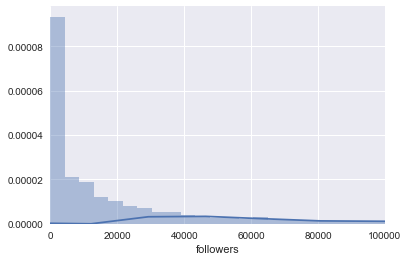

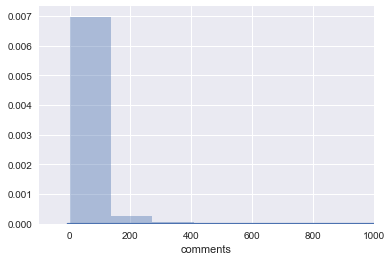

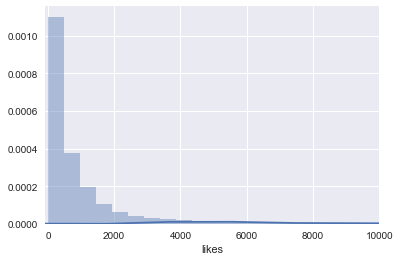

In [9]:
sns.distplot(df2.followers, bins=500)
plt.xlim(-100, 100000)
plt.show()
sns.distplot(df2.comments, bins=500)
plt.xlim(-100, 1000)
plt.show()
sns.distplot(df2.likes, bins=500)
plt.xlim(-100, 10000)
plt.show()

### findings: 
- Clearly our data variables are not normally distributed and skew to the left. We will try to exclude some of our data to determine if we can see these random variables more evenly distributed. 

**First Data Clean**

Anyone with very little reach will skew the data. It's probably a bot. Lets remove all rows where the reach is less than 300.

In [10]:
df2 = df2[(df2['reach']>300)]

Next we decided to remove rows that have less than 1000 followers. This not only helps eliminate outliers but in the data collection there were many rows with exactly zero followers yet high numbers in reach. This data clearly is not correct or not in the style we are looking for. 

In [11]:
df2 = df2[(df2['followers']>1000)]

Setting comments to greater than zero to avoid zero division errors

In [12]:
df2 = df2[(df2['comments']>=1)]

Remove rows with less than 100 likes to eliminate outliers.

In [13]:
df2 = df2[(df2['likes']>=100)]

Remove wierd situations where there are more comments or likes than reach.

In [14]:
df2 = df2.loc[(df2.likes<df2.reach)]
df2 = df2.loc[(df2.comments<df2.reach)]

Now, what does our data look like? 

In [15]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 452928 entries, 0 to 728011
Data columns (total 6 columns):
followers      452928 non-null int64
published      452928 non-null object
likes          452928 non-null int64
comments       452928 non-null int64
impressions    452928 non-null int64
reach          452928 non-null int64
dtypes: int64(5), object(1)
memory usage: 24.2+ MB


# Multicollinearity Of Features

Next we look at full correlation. The test here is to make sure that any two of our variables aren't so correlated that the account for the same effect on the dependent variable.

In [16]:
df2.corr()

,followers,likes,comments,impressions,reach
followers,1.000000,0.681723,0.172782,0.582379,0.566651
likes,0.681723,1.000000,0.273356,0.809560,0.790869
comments,0.172782,0.273356,1.000000,0.208495,0.198823
impressions,0.582379,0.809560,0.208495,1.000000,0.994973
reach,0.566651,0.790869,0.198823,0.994973,1.000000


We noticed that 'likes' and 'followers' have a strong correlation, but not beyond the scope of being used in this model. All other relationships look distant. 

We then created a heat map of the correation numbers to better see which variables we can use. 

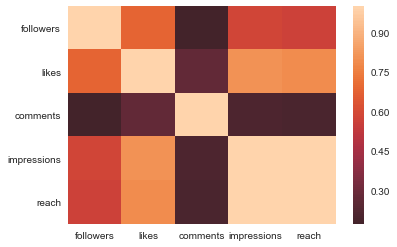

In [17]:
sns.heatmap(df2.corr(), center=0);

Curious to see the time frame of these records. 

In [18]:
print(df2.published.astype('<M8[D]').min())
print(df2.published.astype('<M8[D]').max())

2017-04-18 00:00:00
2018-06-25 00:00:00


We started by testing the coefficents against 'reach' with SKlearn. This module has a linear regression method. 

In [19]:
x = df2[['followers','likes','comments']]
y = df2.reach

In [20]:
from sklearn import linear_model
clf = linear_model.LinearRegression()
clf.fit(x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [21]:
clf.coef_

array([ 0.01607052,  8.53299109, -3.26316479])

In [22]:
type(clf)

sklearn.linear_model.base.LinearRegression

Further we used Statsmodels to create an OLS model. This allows us to see all the import statistics and values associated with the three variables together. 

In [23]:
lr_model = ols(formula='reach~followers + likes + comments', data=df2).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  reach   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                 2.540e+05
Date:                Thu, 07 Mar 2019   Prob (F-statistic):               0.00
Time:                        20:00:38   Log-Likelihood:            -5.1267e+06
No. Observations:              452928   AIC:                         1.025e+07
Df Residuals:                  452924   BIC:                         1.025e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1173.7210     34.128    -34.392      0.000   -1240.611   -1106.831
followers      0.0161      0.000     41.050      0.000       0.015       0.017
likes          8.5330      0.014    599.263      0.000       8.505       8.561
comments      -3.2632      0.171    -19.104      0.000      -3.598      -2.928
==============================================================================
Omnibus:                  1207150.046   Durbin-Watson:                   1.091
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     176505110750.907
Skew:                          31.399   Prob(JB):                         0.00
Kurtosis:                    3060.582   Cond. No.                     1.34e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Immediately we see that there is a high r-squared. This data should be able to be used to predict reach. 

## Scatterplots 
- Next we looked at scatter plots of our data to further look for outliers and the correlation of our independent variable to our dependent variable. 

Text(0.5, 1.0, 'Followers Correlation plot')

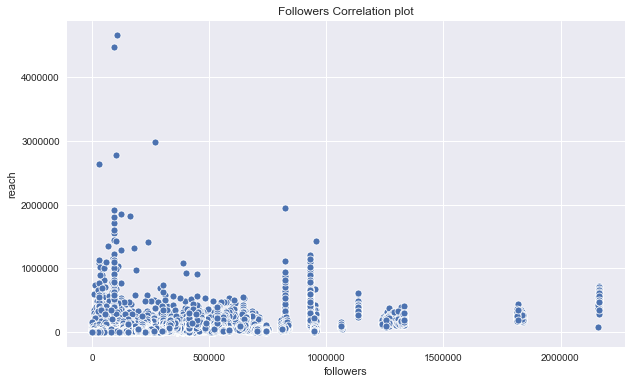

In [24]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df2.followers, y=df2.reach)
plt.xlabel('followers')
plt.ylabel('reach')
plt.title("Followers Correlation plot")
# plt.xlim(0,75_000)
# plt.ylim(0, 1_000_000)

Text(0.5, 1.0, 'Likes Correlation plot')

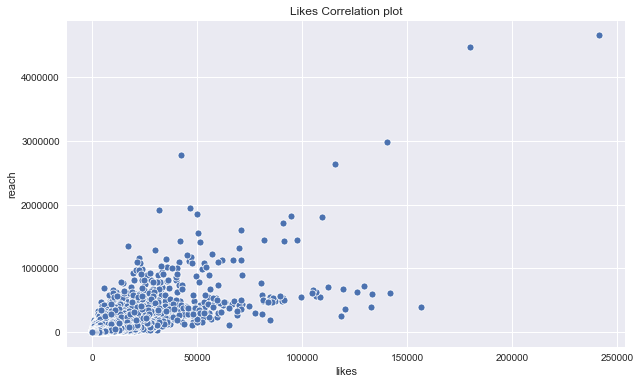

In [25]:
plt.figure(figsize=(10,6))
sns.scatterplot(y=df2.reach, x=df2.likes)
plt.xlabel('likes')
plt.ylabel('reach')
plt.title("Likes Correlation plot")

Text(0.5, 1.0, ' Comments Correlation plot')

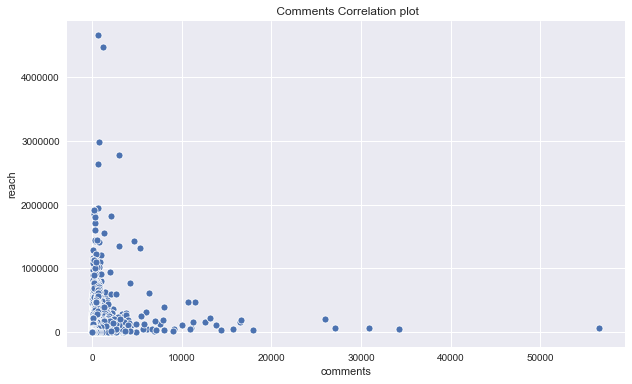

In [26]:
plt.figure(figsize=(10,6))
sns.scatterplot(y=df2.reach, x=df2.comments)
plt.xlabel('comments')
plt.ylabel('reach')
plt.title(" Comments Correlation plot")

**Findings:**
Our data still contains some big outliers and it is not obviously correlated in its current form and scale. Let's remove a few more outliers and check again. 

## Remove extra large users. 

In [27]:
df2 = df2[(df2['followers']<75000)]
df2 = df2[(df2['likes']<75000)]
df2 = df2[(df2['comments']<10000)]

Now that we have cut the top end outliers, Lets run the scatterplots again and models. 

Text(0.5, 1.0, 'Followers Correlation plot')

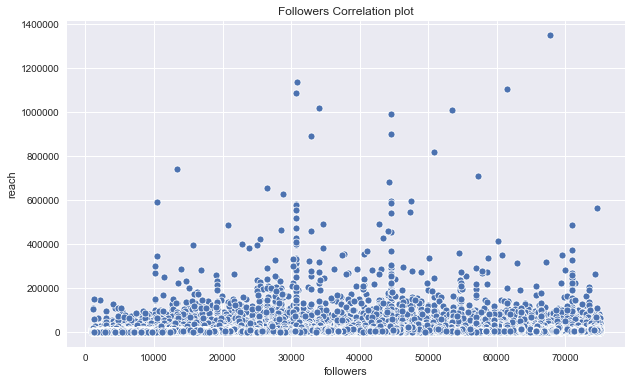

In [28]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df2.followers, y=df2.reach)
plt.xlabel('followers')
plt.ylabel('reach')
plt.title("Followers Correlation plot")

Text(0.5, 1.0, 'Likes Correlation plot')

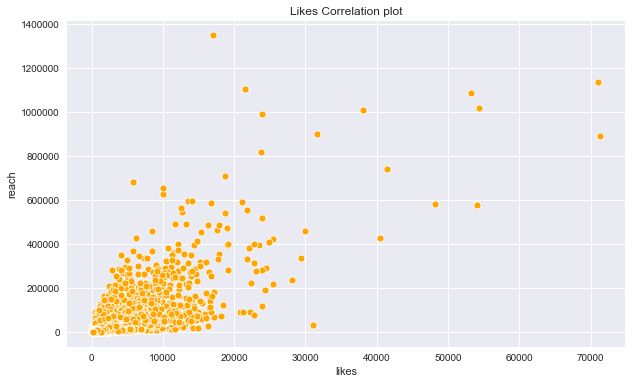

In [29]:
plt.figure(figsize=(10,6))
sns.scatterplot(y=df2.reach, x=df2.likes, color='orange' )
plt.xlabel('likes')
plt.ylabel('reach')
plt.title("Likes Correlation plot")

Text(0.5, 1.0, ' Comments Correlation plot')

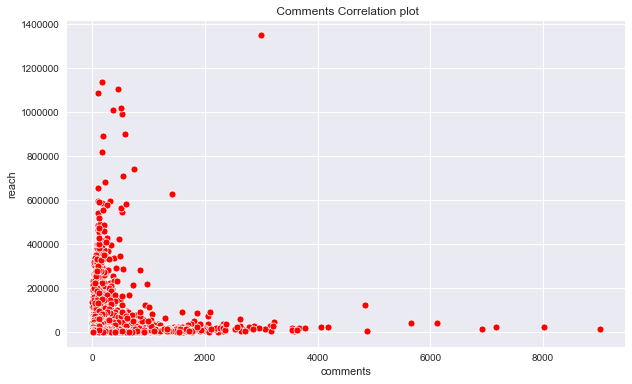

In [30]:
plt.figure(figsize=(10,6))
sns.scatterplot(y=df2.reach, x=df2.comments, color='red')
plt.xlabel('comments')
plt.ylabel('reach')
plt.title(" Comments Correlation plot")

**Findings:**
Our new scatterplots without the extra large users. This has helped some, but not likely enough. We will fit a model again and check for accuracy. 

In [31]:
lr_model = ols(formula='reach~followers + likes + comments', data=df2).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  reach   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                 1.264e+05
Date:                Thu, 07 Mar 2019   Prob (F-statistic):               0.00
Time:                        20:01:05   Log-Likelihood:            -3.8652e+06
No. Observations:              369015   AIC:                         7.730e+06
Df Residuals:                  369011   BIC:                         7.731e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1380.1464     22.762    -60.633      0.000   -1424.760   -1335.533
followers      0.0033      0.001      3.888      0.000       0.002       0.005
likes          9.4501      0.018    536.312      0.000       9.416       9.485
comments      -6.1339      0.203    -30.148      0.000      -6.533      -5.735
==============================================================================
Omnibus:                   970660.882   Durbin-Watson:                   1.323
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      93676823942.981
Skew:                          30.499   Prob(JB):                         0.00
Kurtosis:                    2470.556   Cond. No.                     4.63e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.63e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Findings:** After removing our large users, the r-squared factor has decreased.  This tells us that our outliers might not be identified as simply large. 

## Split the data sets into two - a test and a training data set: 

In [32]:
from sklearn.model_selection import train_test_split
df2, test = train_test_split(df2, test_size=0.2)

Save clean CSV to new file for use on other notebooks.

In [33]:
#df2.to_csv('clean_instagram_train.csv')
#test.to_csv('clean_instagran_test.csv')

## Early Tests

Create a quick function to run the coefficients from the three variables. 

In [34]:
def test_reach(fol, likes, comments):
    return (0.0033*fol) + (9.4501*likes) + (-6.1339 * comments) -1380.1464

In [35]:
test_reach(68172, 107, 1)

-150.15200000000004

(0, 20000)

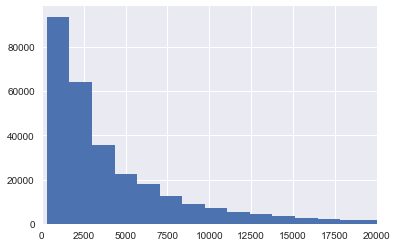

In [36]:
df2['reach'].describe()
plt.hist(df2['reach'],bins=1000)
plt.xlim([0,20000])

## Accuracy Test: Add 'Predicted Reach' to the original data Frame to check for accuracy

In [37]:
df2['test_reach'] = lr_model.predict(df2)

- Use the new prediction column to check to see the difference between the actual

In [38]:
df2['reach_diff'] = df2['reach'] - df2['test_reach']

 - Look at the data again to see the first few examples of difference in reach.

In [39]:
df2.head()

,followers,published,likes,comments,impressions,reach,test_reach,reach_diff
336520,5540,2018-05-07T16:24:58.000+00:00,126,3,629,492,-189.426975,681.426975
678480,7746,2018-06-15T10:31:29.000+00:00,289,26,2979,2144,1217.191620,926.808380
724591,11054,2018-05-24T13:52:01.000+00:00,440,53,3388,2288,2489.534983,-201.534983
235587,8506,2018-06-18T17:01:04.000+00:00,272,6,2742,2132,1181.742234,950.257766
248740,6197,2017-11-03T17:29:34.000+00:00,119,1,1195,1006,-241.127047,1247.127047


- Add a ratio column to check for overall accuracy of all the predictions. 

In [40]:
df2['diff_ratio'] = (df2.reach_diff / df2.reach)*100

- Plot the view of our ratio. As our ratio approaches zero, the prediction is most accurate. This trial is not perfect, but this view provides some confidence that we might be able to make a worth while perdiction with the model. 

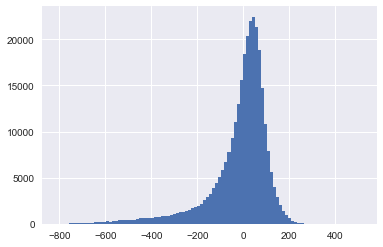

In [41]:
x = plt.hist(df2.diff_ratio, bins = 100)

- We next calculated the Root Mean Squared Error to see how far off our data might be from 0, our most acurate result. 

In [42]:
mean_squared_error(df2.reach, df2.test_reach)**.5

8885.956766062256

## Interactions.
Lets create a plot to see if the three variables are interacting with each other in the model. 

In [43]:
from sklearn.linear_model import LinearRegression
regression_1 = LinearRegression()
regression_2 = LinearRegression()
regression_3 = LinearRegression()

likes = df2["likes"].values.reshape(-1, 1)
comments = df2["comments"].values.reshape(-1, 1)
followers = df2["followers"].values.reshape(-1, 1)

regression_1.fit(likes, df2["reach"])
regression_2.fit(comments, df2["reach"])
regression_3.fit(followers, df2["reach"])

# Make predictions using the testing set
pred_1 = regression_1.predict(likes)
pred_2 = regression_2.predict(comments)
pred_3 = regression_3.predict(followers)

# The coefficients
print(regression_1.coef_)
print(regression_2.coef_)
print(regression_3.coef_)

[9.50274375]
[31.08813738]
[0.21317087]


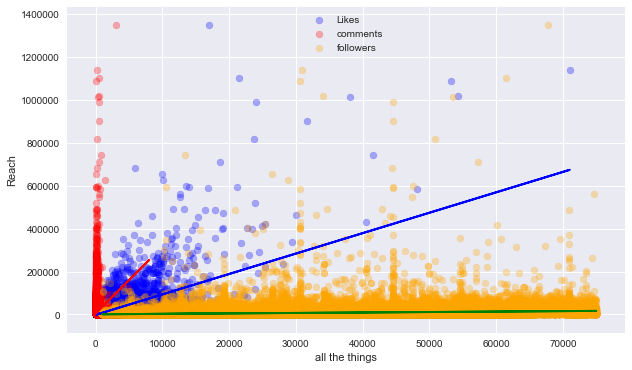

In [44]:
# Plot outputs
plt.figure(figsize=(10,6))

plt.scatter(likes, df2["reach"],  color='blue', alpha = 0.3, label = "Likes")
plt.scatter(comments, df2["reach"],  color='red', alpha = 0.3, label = "comments")
plt.scatter(followers, df2["reach"],  color='orange', alpha = 0.3, label = "followers")

plt.plot(likes, pred_1,  color='blue', linewidth=2)
plt.plot(comments, pred_2,  color='red', linewidth=2)
plt.plot(followers, pred_3,  color='green', linewidth=2)
plt.ylabel("Reach")
plt.xlabel("all the things")
plt.legend();

## Summary of Trial 1

We did a simple test of just one test subject with a follower count near the mean.  This produced a reach of -110.50. This of course is not possible. Thus we decide to move onto a different path. We will use a Logorithmic transformation to set our variables closer to each other. 